Solve: 
$$\large \dfrac{\partial u(x, t)}{\partial t} = \kappa \dfrac{\partial^2 u(x,t)}{\partial t^2}$$
on the computational domain x $\in [0, 1]$ with $\Delta x = 0.1$, initial value $u(x,0) = x(1 - x)$ and boundary values $u(0, t) = u(1, t) = 0$. Assume $\kappa = 1$

In [9]:
### Imports and Auxiliary Function Definitions

import numpy as np
import matplotlib.pyplot as plt

def u_init(x): # initial value
    return(x * (1 - x))

def TriSolve(a, b, c, r):
    
    """
    Outputs the solution of a tridiagonal matrix with.
    Inputs : a, b, c, r
        Vectors, representing the sub-main, main and super-main diagonals and the vector of coefficients.
    Outputs : solutions
        Vector, solution to the tridiagonal matrix.
    """
    
    n = np.size(b)
    beta = np.zeros(n)
    rho = np.zeros(n)
    solutions = np.zeros(n)
    
    beta[0] = b[0]
    rho[0] = r[0]
    
    for j in range(1, n):
        beta[j] = b[j] - ( a[j-1] / beta[j-1] ) * c[j-1]
        rho[j] = r[j] - ( a[j-1] / beta[j-1] ) * rho[j-1]
    
    solutions[n-1] = rho[n-1]/beta[n-1]
    
    for j in range(n-1):
        solutions[n-j-2] = (rho[n-j-2] - c[n-j-2] * solutions[n-j-1])/beta[n-j-2]
        
    return solutions

def CN_r(x, alpha): # sets RHS for Crank-Nicholson scheme
    J = np.size(x) - 1
    r = []
    for i in range(1, J):
        value = alpha * x[i + 1] + (1 - 2 * alpha) * x[i] + alpha * x[i-1]
        r.append(value)
    r.append(x[-1])
    r.insert(0, x[0])
    r = np.array(r)
    return(r)

In [10]:
### Main PDE Solver Definitions

def FTCS(initial_values, delta_t, delta_x = 0.1, k = 1):
    """
    This function evolves the given initial values in time, as per the given time-step value (delta_x) and the space-step value
    (delta_x), according to the Forward Time Centered Space (FTCS) differencing scheme. The diffusion coefficient (k) can also
    be given. The stability criterion is that given by a local von Neumann stability analysis.
    """
    x = np.arange(0, 1 + delta_x, delta_x)
    t = np.arange(0, 1 + delta_t, delta_t)
    u = np.zeros((np.size(t), np.size(x)))
    u[0, :] = initial_values
    r = (k * delta_t) / (delta_x ** 2)
    for n in range(np.size(t) - 1):
        for j in range(1, np.size(x) - 1):
            u[n + 1, j] = (1 - 2 * r) * u[n, j] + r * (u[n, j+1] + u[n, j-1])
    return(u)

def BTCS(initial_values, delta_t, delta_x = 0.1, k = 1):
    """
    This function evolves the given initial values in time, as per the given time-step value (delta_x) and the space-step value
    (delta_x), according to the Backward Time Centered Space (BTCS) (or the fully implicit) differencing scheme.
    The diffusion coefficient (k) can also be given. At each time step, a tridiagonal matrix is solved for the value at the 
    next time-step. The stability criterion is that given by a local von Neumann stability analysis.
    """
    J = int((1 - 0) / delta_x)
    N = int((1 - 0) / delta_t)
    alpha = (k * delta_t) / (delta_x ** 2)
    a = [-alpha] * (J - 1)
    a.append(0)
    b = [1 + 2 * alpha] * (J + 1)
    c = [-alpha] * (J - 1)
    c.insert(0, 0)
    a, b, c = np.array(a), np.array(b), np.array(c)
    r = initial_values
    solutions = np.zeros((N + 1, J + 1))
    solutions[0, :] = initial_values 
    for time in range(1, N + 1):
        solutions[time, : ] = TriSolve(a, b, c, r)
        r = solutions[time, :]
    return(solutions)

def CrankNicholson(initial_values, delta_t, delta_x = 0.1, k = 1):
    """
    This function evolves the given initial values in time, as per the given time-step value (delta_x) and the space-step value
    (delta_x), according to the Crank-Nicholson (or the partially implicit) differencing scheme.
    The diffusion coefficient (k) can also be given. At each time step, a tridiagonal matrix is solved for the value at the 
    next time-step. The stability criterion is that given by a local von Neumann stability analysis.
    """
    J = int((1 - 0) / delta_x)
    N = int((1 - 0) / delta_t)
    alpha = (k * delta_t) / (2 * (delta_x ** 2))
    a = [-alpha] * (J - 1)
    a.append(0)
    b = [1 + 2 * alpha] * (J + 1)
    c = [-alpha] * (J - 1)
    c.insert(0, 0)
    a, b, c = np.array(a), np.array(b), np.array(c)
    r = CN_r(initial_values, alpha)
    solutions = np.zeros((N + 1, J + 1))
    solutions[0, :] = initial_values 
    for time in range(1, N + 1):
        solutions[time, : ] = TriSolve(a, b, c, r)
        r = CN_r(solutions[time, :], alpha)
    return(solutions)

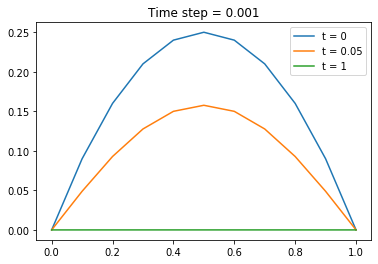

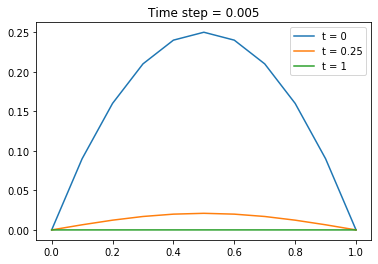

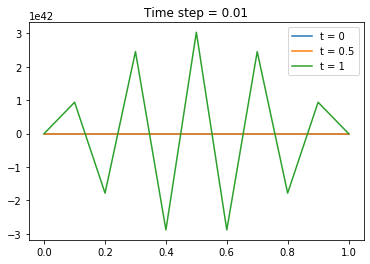

In [11]:
### Testing out the FTCS differencing scheme

delta_x = 0.1
k = 1
J = int((1 - 0) / delta_x)

delta_t = np.array([0.001, 0.005, 0.01])
init_vals = u_init(np.arange(0, 1.1, 0.1))
for time_step in delta_t:
    N = int((1 - 0) / time_step)
    ftcs_sol = FTCS(init_vals, time_step, delta_x, k)
    fig = plt.figure()
    if(time_step == 0.001):
        capture = ftcs_sol
    plt.title('Time step = ' + str(time_step))
    plt.plot(np.arange(0, 1.1, 0.1), ftcs_sol[0, :], label = 't = 0')
    plt.plot(np.arange(0, 1.1, 0.1), ftcs_sol[50, :], label = 't = ' + str(time_step * 50))
    plt.plot(np.arange(0, 1.1, 0.1), ftcs_sol[-1, :], label = 't = 1')
    plt.legend()

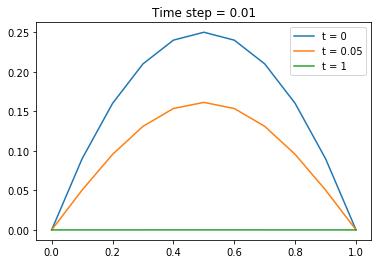

In [17]:
### Testing out the BTCS differencing scheme

delta_x = 0.1
k = 1
J = int((1 - 0) / delta_x)

delta_t = 0.01
init_vals = u_init(np.arange(0, 1.1, 0.1))
btcs_sol = BTCS(init_vals, delta_t, delta_x, k)
fig = plt.figure()
plt.title('Time step = ' + str(delta_t))
plt.plot(np.arange(0, 1.1, 0.1), btcs_sol[0, :], label = 't = 0')
plt.plot(np.arange(0, 1.1, 0.1), btcs_sol[5, :], label = 't = ' + str(delta_t * 5))
plt.plot(np.arange(0, 1.1, 0.1), btcs_sol[-1, :], label = 't = 1')
plt.legend()

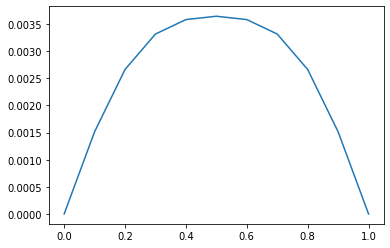

In [19]:
plt.plot(np.arange(0, 1.1, 0.1), btcs_sol[5, :] - capture[50, :])

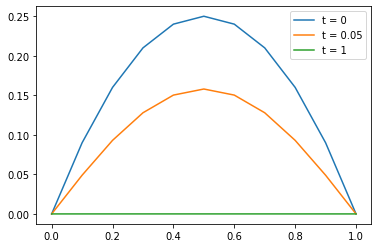

In [14]:
### Testing out the Crank-Nicholson differencing scheme

delta_x = 0.1
k = 1
J = int((1 - 0) / delta_x)

delta_t = 0.01
init_vals = u_init(np.arange(0, 1.1, 0.1))
cn_sol = CrankNicholson(init_vals, delta_t, delta_x, k)
fig = plt.figure()
plt.plot(np.arange(0, 1.1, 0.1), cn_sol[5, :], label = 't = ' + str(delta_t * 5))
plt.plot(np.arange(0, 1.1, 0.1), btcs_sol[5, :], label = 't = ' + str(delta_t * 5))

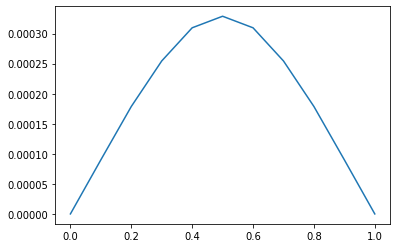

In [15]:
plt.plot(np.arange(0, 1.1, 0.1), cn_sol[5, :] - capture[50, :])

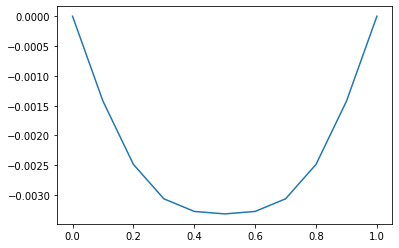

In [16]:
plt.plot(np.arange(0, 1.1, 0.1), cn_sol[5, :] - btcs_sol[5, :])